In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())


text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64


In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(train_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>
<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>


In [7]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])


texts:  [b'All films made before 1912 really need to be viewed with a sense of time and place.<br /><br />In 1894, the Lumiere-family men [father: Antoine (1840-1911), sons: Auguste and Louis] owned and managed a factory that manufactured photographic plates and paper. Not a small enterprise; the factory had more than 200 employees who received pension and social security benefits - innovative for that time. It was located at Montplaisir in the suburbs of Lyon, France. What caused Louis Lumiere to become interested in building a Cinematagraph, in 1894, remains open for speculation. My suggestion is that the appearance of the Edison organization\'s Kinetoscope (peep-show machine), in Paris during the fall of 1894, provided the catalyst.<br /><br />W.K.L. Dickson, of Edison\'s staff, invented a motion-picture camera about the size of an upright piano that was patented in February 1893. It was electrically operated (using power from from heavy storage batteries. This massive machine pumpe

In [8]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))


In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example


array([[ 32,  95,  91, ...,   0,   0,   0],
       [256,   9,  42, ...,   0,   0,   0],
       [ 10, 412, 434, ...,   0,   0,   0]])

In [11]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()


Original:  b'All films made before 1912 really need to be viewed with a sense of time and place.<br /><br />In 1894, the Lumiere-family men [father: Antoine (1840-1911), sons: Auguste and Louis] owned and managed a factory that manufactured photographic plates and paper. Not a small enterprise; the factory had more than 200 employees who received pension and social security benefits - innovative for that time. It was located at Montplaisir in the suburbs of Lyon, France. What caused Louis Lumiere to become interested in building a Cinematagraph, in 1894, remains open for speculation. My suggestion is that the appearance of the Edison organization\'s Kinetoscope (peep-show machine), in Paris during the fall of 1894, provided the catalyst.<br /><br />W.K.L. Dickson, of Edison\'s staff, invented a motion-picture camera about the size of an upright piano that was patented in February 1893. It was electrically operated (using power from from heavy storage batteries. This massive machine pum

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [13]:
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])


[-0.00387598]


In [15]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])


[-0.00387598]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)


Epoch 1/10
391/391 [==============================] - 259s 653ms/step - loss: 0.6827 - accuracy: 0.5165 - val_loss: 0.5124 - val_accuracy: 0.7458
Epoch 2/10
391/391 [==============================] - 254s 649ms/step - loss: 0.4437 - accuracy: 0.7909 - val_loss: 0.3721 - val_accuracy: 0.8271
Epoch 3/10
391/391 [==============================] - 251s 642ms/step - loss: 0.3455 - accuracy: 0.8454 - val_loss: 0.3376 - val_accuracy: 0.8531
Epoch 4/10
391/391 [==============================] - 252s 645ms/step - loss: 0.3201 - accuracy: 0.8605 - val_loss: 0.3290 - val_accuracy: 0.8552
Epoch 5/10
391/391 [==============================] - 252s 645ms/step - loss: 0.3094 - accuracy: 0.8683 - val_loss: 0.3342 - val_accuracy: 0.8385
Epoch 6/10
391/391 [==============================] - 252s 646ms/step - loss: 0.3051 - accuracy: 0.8681 - val_loss: 0.3232 - val_accuracy: 0.8552
Epoch 7/10
391/391 [==============================] - 251s 643ms/step - loss: 0.3045 - accuracy: 0.8678 - val_loss: 0.3237 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))


391/391 [==============================] - 70s 179ms/step - loss: 0.3236 - accuracy: 0.8502
Test Loss: 0.32362669706344604
Test Accuracy: 0.8501600027084351


(0.0, 0.6645468294620513)

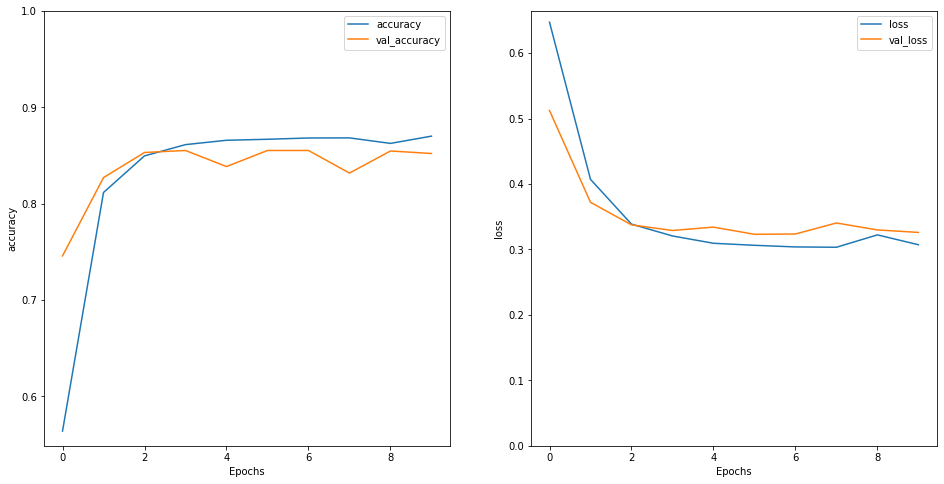

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)


In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))


In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/10
391/391 [==============================] - 489s 1s/step - loss: 0.6656 - accuracy: 0.5303 - val_loss: 0.4108 - val_accuracy: 0.8151
Epoch 2/10
391/391 [==============================] - 477s 1s/step - loss: 0.3930 - accuracy: 0.8303 - val_loss: 0.3423 - val_accuracy: 0.8458
Epoch 3/10
391/391 [==============================] - 476s 1s/step - loss: 0.3336 - accuracy: 0.8602 - val_loss: 0.3279 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 476s 1s/step - loss: 0.3216 - accuracy: 0.8645 - val_loss: 0.3209 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 469s 1s/step - loss: 0.3144 - accuracy: 0.8682 - val_loss: 0.3200 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 468s 1s/step - loss: 0.3001 - accuracy: 0.8717 - val_loss: 0.3238 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 476s 1s/step - loss: 0.2988 - accuracy: 0.8721 - val_loss: 0.3144 - val_accuracy: 0.8578

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)


[[-2.1584322]]


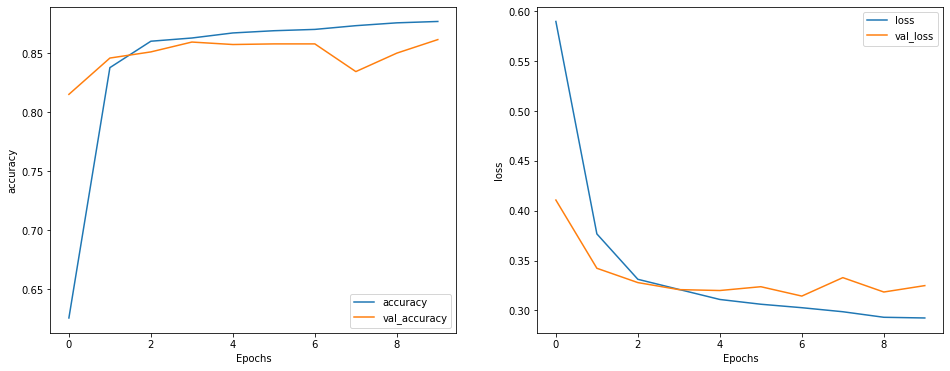

In [25]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
